# COGS 108 - Final Project 

# Overview

*Fill in your overview here*

# Names

- Karen Rodriguez Pinto
- Enlin Wei
- Yumi Minami 
- Kanami Hannah Tanaka

# Group Members IDs

- A15161856
- A12938737
- A12669124
- A########

# Research Question

*Fill in your research question here*

## Background and Prior Work

*Fill in your background and prior work here* 

References (include links):
- 1)
- 2)

# Hypothesis


*Fill in your hypotheses here*

# Dataset(s)

- Dataset Name: Kickstarter Campaigns
- Link to the dataset: https://www.kaggle.com/yashkantharia/kickstarter-campaigns
- Number of observations: 192548

This dataset contains information about Kickstarter crowdfunding campaigns from 2014 to February 2019. The information includes the names, currency, main and subcategories, launch date and deadlines, goal amount of money to raise and actual amounts raised, whether the campaign was successful or failed, and geographical locations of the campaigns (country and state).

# Setup

In [1]:
# imports
%matplotlib inline

import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

In [2]:
# loads Kickstarters data into dataframe
df_kickstarters = pd.read_csv("Kickstarter_projects_Feb19.csv")

In [3]:
# viewing the first rows of the dataframe
df_kickstarters.head()

,id,name,currency,main_category,sub_category,launched_at,deadline,duration,goal_usd,city,state,country,blurb_length,name_length,status,start_month,end_month,start_Q,end_Q,usd_pledged
0,1687733153,Socks of Speed and Socks of Elvenkind,USD,games,Tabletop Games,2018-10-30 20:00:02,2018-11-15 17:59:00,16.0,2000.00000,Menasha,WI,US,14,7,successful,10,11,Q4,Q4,6061.00000
1,227936657,Power Punch Boot Camp: An All-Ages Graphic Novel,GBP,comics,Comic Books,2018-08-06 10:00:43,2018-09-05 10:00:43,30.0,3870.99771,Shepperton,England,GB,24,8,successful,8,9,Q3,Q3,3914.50512
2,454186436,"Live Printing with SX8: ""Squeegee Pulp Up""",USD,fashion,Apparel,2017-06-09 15:41:03,2017-07-09 15:41:03,30.0,1100.00000,Manhattan,NY,US,21,7,successful,6,7,Q2,Q3,1110.00000
3,629469071,Lost Dog Street Band's Next Album,USD,music,Country & Folk,2014-09-25 18:46:01,2014-11-10 06:00:00,45.0,3500.00000,Nashville,TN,US,15,6,successful,9,11,Q3,Q4,4807.00000
4,183973060,"Qto-X, a Tiny Lantern",USD,technology,Gadgets,2016-11-28 16:35:11,2017-01-27 16:35:11,60.0,30000.00000,Troy,MI,US,15,4,successful,11,1,Q4,Q1,40368.00000


# Data Cleaning

We first checked to see if any cell has null values, and if so to drop those entries.

In [4]:
df_kickstarters[df_kickstarters.isnull().any(axis=1)]

,id,name,currency,main_category,sub_category,launched_at,deadline,duration,goal_usd,city,state,country,blurb_length,name_length,status,start_month,end_month,start_Q,end_Q,usd_pledged


We found no null values in the dataset, and so we proceeded with data cleaning.

We first dropped the column 'id' since it gives no useful information, just an ID associated with the project. We then dropped columns 'start_month' and 'end_month' since the information about the start and end months of the projects are already given in the dates in the 'launched_at' and 'deadline' columns and so is redundant.

In [5]:
df_kickstarters.drop(columns=['id', 'start_month', 'end_month'], inplace=True)

We then noticed that the **launched_at** and **deadline** columns contained dates and times of when the projects were launched and ended in string format. It would be easier to work with datetime objects, so we replaced the strings with datetime objects.

In [6]:
# method to convert datetime strings in 'df_kickstarters' into datetime objects
def to_datetime(datetime_str):
    return dt.datetime.strptime(datetime_str, '%Y-%m-%d %H:%M:%S')

In [7]:
# converts all datetime strings in df to datetime objects
df_kickstarters['launched_at'] = df_kickstarters['launched_at'].apply(to_datetime)
df_kickstarters['deadline'] = df_kickstarters['deadline'].apply(to_datetime)

Finally, we noticed some of the monetary amounts have more than 2 decimal places, which should be cleaned up since we don't work with monetary amounts more specific than 2 decimal places. So we decided to round the amounts to 2 decimal places.

In [8]:
df_kickstarters['goal_usd'] = df_kickstarters['goal_usd'].round(2)
df_kickstarters['usd_pledged'] = df_kickstarters['usd_pledged'].round(2)

# Data Analysis & Results

Since our project aims to analyze which factor is most important for the success of kickstarters, we will divide the dataframe into two separate ones, one with all the successful projects and one with all the failed projects.

In [10]:
df_successful = df_kickstarters[df_kickstarters['status']=='successful']
df_failed = df_kickstarters[df_kickstarters['status']=='failed']

In [11]:
# views first rows of df_kickstarters
df_kickstarters.head()

,name,currency,main_category,sub_category,launched_at,deadline,duration,goal_usd,city,state,country,blurb_length,name_length,status,start_Q,end_Q,usd_pledged
0,Socks of Speed and Socks of Elvenkind,USD,games,Tabletop Games,2018-10-30 20:00:02,2018-11-15 17:59:00,16.0,2000.0,Menasha,WI,US,14,7,successful,Q4,Q4,6061.00
1,Power Punch Boot Camp: An All-Ages Graphic Novel,GBP,comics,Comic Books,2018-08-06 10:00:43,2018-09-05 10:00:43,30.0,3871.0,Shepperton,England,GB,24,8,successful,Q3,Q3,3914.51
2,"Live Printing with SX8: ""Squeegee Pulp Up""",USD,fashion,Apparel,2017-06-09 15:41:03,2017-07-09 15:41:03,30.0,1100.0,Manhattan,NY,US,21,7,successful,Q2,Q3,1110.00
3,Lost Dog Street Band's Next Album,USD,music,Country & Folk,2014-09-25 18:46:01,2014-11-10 06:00:00,45.0,3500.0,Nashville,TN,US,15,6,successful,Q3,Q4,4807.00
4,"Qto-X, a Tiny Lantern",USD,technology,Gadgets,2016-11-28 16:35:11,2017-01-27 16:35:11,60.0,30000.0,Troy,MI,US,15,4,successful,Q4,Q1,40368.00


In [12]:
ttest_ind(df_successful['duration'],df_failed['duration'],equal_var=False)

Ttest_indResult(statistic=-67.02678596731965, pvalue=0.0)

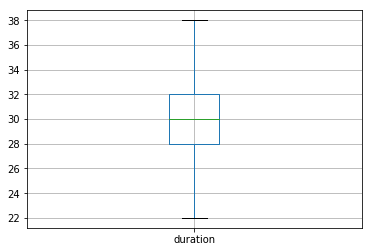

In [13]:
df_successful.boxplot(column=['duration'],showfliers=False)

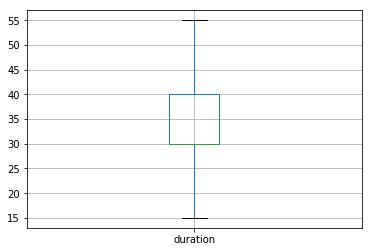

In [14]:
df_failed.boxplot(column=['duration'],showfliers=False)

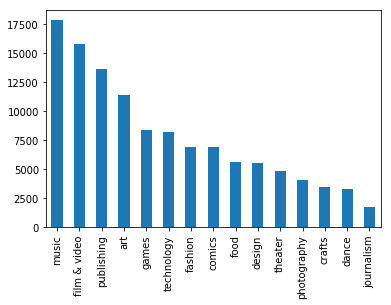

In [15]:
# plots histogram of column 'main category' of successful projects
df_successful['main_category'].value_counts().plot(kind='bar')

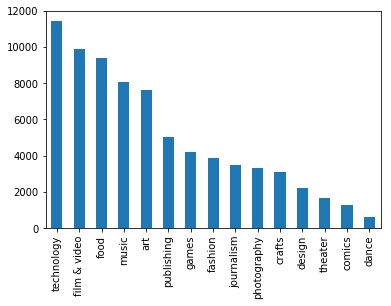

In [16]:
# plots histogram of column 'main category' of failed projects
df_failed['main_category'].value_counts().plot(kind='bar')

In [17]:
## YOUR CODE HERE
## FEEL FREE TO ADD MULTIPLE CELLS PER SECTION

# Ethics & Privacy

*Fill in your ethics & privacy discussion here*

# Conclusion & Discussion

*Fill in your discussion information here*